## Feature creation.

### Load packages and data files

In [67]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict


In [68]:
#import data
df_results = pd.read_csv('../data/nfl_games_pfr.csv')
print(df_results.columns)
print(len(df_results[~df_results['Margin Yds'].isna()]))

Index(['Unnamed: 0', 'Week', 'Day', 'Date', 'Time', 'Winner', 'LoserIsHome',
       'Loser', 'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week',
       'Winner Abbr', 'Loser Abbr', 'Home Team', 'Away Team', 'Home Score',
       'Away Score', 'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO',
       'Loser TO', 'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away'],
      dtype='object')
2517


### Create rankings using pagerank from nx

In [69]:
# Graph Functions
def create_graph(game_data, week_num):
    G = nx.DiGraph()
    margin_totals = defaultdict(float)
    game_counts = defaultdict(int)
    
    # Iterate over each game result
    for _, row in game_data.iterrows():
        winner = row['winner']
        loser = row['loser']
        week = row['week']
        margin = row['margin']

        key = (loser, winner)
        margin_totals[key] += margin
        game_counts[key] += 1

    # Add edges with average margin as weight
    for (loser, winner), total_margin in margin_totals.items():
        avg_margin = total_margin / game_counts[(loser, winner)]
        G.add_edge(loser, winner, weight=avg_margin)
    
    return G

# Function to calculate rankings based on the weighted graph
def calculate_rankings(graph):
    # Calculate PageRank with weights
    return pd.DataFrame(nx.pagerank(graph, alpha=0.95, weight='weight').items(), columns=['Team', 'Ranking'])

# Function to generate rankings for each season and week
def generate_rankings(df_filtered, feature_type):
    # Initialize an empty list to store rankings DataFrames
    ranking_dfs = []

    # Loop over each distinct season in the dataset
    for season in df_filtered['season'].unique():
        # Filter the game data for the current season
        season_data = df_filtered[df_filtered['season'] == season]
        
        # Loop over the weeks for this season
        for week in range(2, season_data['week'].max() + 1):
            # Filter the game data up to the current week for the current season
            filtered_data = season_data[season_data['week'] <= week]
            
            # Create the directed graph for the current season and weeks
            G = create_graph(filtered_data, week)
            
            # Calculate the rankings based on the weighted graph
            rankings = calculate_rankings(G)

            # Round the rankings to 4 decimal places
            rankings['Ranking'] = rankings['Ranking'].round(5)
            
            # Add columns indicating the season and week, with a leading zero for weeks
            rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
            rankings['Season'] = season
            rankings['Week'] = week
            rankings['Type'] = feature_type
            
            # Append the rankings to the list
            ranking_dfs.append(rankings)
    
    # Concatenate all rankings DataFrames into a single DataFrame
    return pd.concat(ranking_dfs)

print("DONE")

DONE


In [70]:
# Function to calculate the Strength of Schedule (SoS)
def calculate_strength_of_schedule(graph, pagerank):
    sos = defaultdict(float)
    for team in graph.nodes:
        opponents = list(graph.predecessors(team)) + list(graph.successors(team))
        if opponents:
            sos[team] = sum(pagerank.get(opponent, 0) for opponent in opponents) / len(opponents)
        else:
            sos[team] = 0
    return sos

# Function to generate rankings for each season and week with SoS and iteration
def generate_rankings_with_sos(df_filtered, feature_type, iterations=20):
    # Initialize an empty list to store rankings DataFrames
    ranking_dfs = []

    # Loop over each distinct season in the dataset
    for season in df_filtered['season'].unique():
        # Filter the game data for the current season
        season_data = df_filtered[df_filtered['season'] == season]

        # Loop over the weeks for this season
        for week in range(2, season_data['week'].max() + 1):
            # Filter the game data up to the current week for the current season
            filtered_data = season_data[season_data['week'] <= week]
            
            # Create the directed graph for the current season and weeks
            G = create_graph(filtered_data, week)
            
            # Initial PageRank calculation
            pagerank = dict(nx.pagerank(G, alpha=0.9, weight='weight'))

            # Iteratively refine the rankings with SoS
            for _ in range(iterations):
                sos = calculate_strength_of_schedule(G, pagerank)
                
                # Adjust rankings based on strength of schedule
                adjusted_pagerank = {}
                for team, rank in pagerank.items():
                    adjusted_pagerank[team] = rank * (1 + sos[team])  # Adjust by SoS
                
                # Normalize adjusted PageRank
                total_rank = sum(adjusted_pagerank.values())
                pagerank = {team: rank / total_rank for team, rank in adjusted_pagerank.items()}

            # Convert pagerank dict to DataFrame
            rankings = pd.DataFrame(pagerank.items(), columns=['Team', 'Ranking'])

            # Round the rankings to 5 decimal places
            rankings['Ranking'] = rankings['Ranking'].round(5)
            
            # Add columns indicating the season and week, with a leading zero for weeks
            rankings['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
            rankings['Season'] = season
            rankings['Week'] = week
            rankings['Type'] = feature_type
            
            # Append the rankings to the list
            ranking_dfs.append(rankings)
    
    # Concatenate all rankings DataFrames into a single DataFrame
    return pd.concat(ranking_dfs)

In [71]:
### OFFENSE ###
# Filtered data frames for each feature set
df_offense = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner Yds','Loser Yds','Margin Yds']]
df_offense = df_offense.rename(columns={'Winner Yds':'winner', 'Loser Yds':'loser','Margin Yds':'margin'})

# Generate rankings for each feature type
#final_offense_rankings_df = generate_rankings(df_offense, "Offense")
final_offense_rankings_df = generate_rankings_with_sos(df_offense, "Offense")
print(final_offense_rankings_df.head())
print(len(final_offense_rankings_df))

  Team  Ranking SeasonWeek  Season  Week     Type
0   KC  0.00824   2024_W02    2024     2  Offense
1  BAL  0.01699   2024_W02    2024     2  Offense
2  PHI  0.00787   2024_W02    2024     2  Offense
3   GB  0.00971   2024_W02    2024     2  Offense
4  ATL  0.01507   2024_W02    2024     2  Offense
5056


In [72]:
### DEFENSE ###
# Filtered data frames for each feature set
df_defense = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner TO','Loser TO','Margin TO']]
df_defense = df_defense.rename(columns={'Winner TO':'winner', 'Loser TO':'loser','Margin TO':'margin'})

# Generate rankings for each feature type
#final_defense_rankings_df = generate_rankings(df_defense, "Defense")
final_defense_rankings_df = generate_rankings_with_sos(df_defense, "Defense")
print(final_defense_rankings_df.head())
print(len(final_defense_rankings_df))

  Team  Ranking SeasonWeek  Season  Week     Type
0  BAL  0.02944   2024_W02    2024     2  Defense
1   KC  0.04842   2024_W02    2024     2  Defense
2   GB  0.02208   2024_W02    2024     2  Defense
3  PHI  0.04614   2024_W02    2024     2  Defense
4  PIT  0.01657   2024_W02    2024     2  Defense
5056


In [73]:
### SCORE ###
# Filtered data frames for each feature set
df_score = df_results[~df_results['Margin Yds'].isna()][['season','week','Winner Abbr','Loser Abbr','Margin Pts']]
df_score = df_score.rename(columns={'Winner Abbr':'winner', 'Loser Abbr':'loser', 'Margin Pts':'margin'})

# Generate rankings for each feature type
#final_score_rankings_df = generate_rankings(df_score, "Score")
final_score_rankings_df = generate_rankings_with_sos(df_score, "Score")
print(final_score_rankings_df.head())
print(len(final_score_rankings_df))

  Team  Ranking SeasonWeek  Season  Week   Type
0  BAL  0.01243   2024_W02    2024     2  Score
1   KC  0.01916   2024_W02    2024     2  Score
2   GB  0.02459   2024_W02    2024     2  Score
3  PHI  0.05097   2024_W02    2024     2  Score
4  ATL  0.09120   2024_W02    2024     2  Score
5056


In [74]:
# Concatenate all feature rankings into a single DataFrame
final_rankings_df = pd.concat([final_offense_rankings_df, final_score_rankings_df, final_defense_rankings_df])
print(final_rankings_df.head())
print(len(final_rankings_df))
final_rankings_df.to_csv('../data/nfl_rankings_combined.csv')

  Team  Ranking SeasonWeek  Season  Week     Type
0   KC  0.00824   2024_W02    2024     2  Offense
1  BAL  0.01699   2024_W02    2024     2  Offense
2  PHI  0.00787   2024_W02    2024     2  Offense
3   GB  0.00971   2024_W02    2024     2  Offense
4  ATL  0.01507   2024_W02    2024     2  Offense
15168


In [75]:
def filter_data_for_game(game_row, full_data):
    current_season = game_row['season']
    current_week = game_row['week']
    
    # Get relevant seasons: current season and previous 3
    relevant_seasons = [current_season - i for i in range(4)]
    
    # Filter data to only include these seasons
    filtered_data = full_data[(full_data['season'].isin(relevant_seasons)) & 
                              ((full_data['season'] < current_season) | 
                               ((full_data['season'] == current_season) & 
                                (full_data['week'] < current_week)))]
    
    return filtered_data

In [76]:
df_fieldadv = df_results[~df_results['Margin Yds'].isna()][['season','week','Home Team','Away Team','Home Score', 'Away Score']]
df_fieldadv['Margin HomeAway'] = df_fieldadv['Home Score'] - df_fieldadv['Away Score']

# List to store the aggregated team-level impacts across all weeks
all_team_impacts = []

# Dictionary to store performance data for home and away impacts
home_away_impacts = []

# Iterate over each season and week in the dataset
for season in df_fieldadv['season'].unique():
    for week in df_fieldadv[df_fieldadv['season'] == season]['week'].unique():
        # Filter games up to the current season and week, including the current season and the three prior seasons
        relevant_games = df_fieldadv[(df_fieldadv['season'] >= (season - 3)) & ((df_fieldadv['season'] < season) | ((df_fieldadv['season'] == season) & (df_fieldadv['week'] <= week)))]
        
        # Get a list of unique teams for the relevant period
        teams = relevant_games['Home Team'].unique()
        
        for team in teams:
            # Filter games where the team is either home or away
            home_games = relevant_games[relevant_games['Home Team'] == team]
            away_games = relevant_games[relevant_games['Away Team'] == team]

            # Iterate over each opponent the team has faced
            for opponent in home_games['Away Team'].unique():
                # Check if the team played both a home and away game against this opponent
                if opponent in away_games['Home Team'].values:
                    # Home game(s) against this opponent
                    home_matchups = home_games[home_games['Away Team'] == opponent]
                    # Away game(s) against this opponent
                    away_matchups = away_games[away_games['Home Team'] == opponent]

                    # Ensure there is at least one home and one away game
                    if not home_matchups.empty and not away_matchups.empty:
                        # Compute the average points differential at home and away
                        home_avg_diff = home_matchups['Margin HomeAway'].mean()
                        away_avg_diff = away_matchups['Margin HomeAway'].mean()

                        # Count the number of matchups used in the calculations
                        num_matchups = len(home_matchups) + len(away_matchups)

                        # Store the impact data for home and away
                        home_away_impacts.append({
                            'Team': team,
                            'Opponent': opponent,
                            'Home_Avg_Diff': home_avg_diff,
                            'Away_Avg_Diff': away_avg_diff,
                            'Home_Impact': home_avg_diff - away_avg_diff,
                            'Away_Impact': away_avg_diff - home_avg_diff,
                            'Matchup_Count': num_matchups,
                            'SeasonWeek': f"{season}_W{str(week).zfill(2)}"
                        })

        # Convert the results to a DataFrame for the current season and week
        home_away_impact_df = pd.DataFrame(home_away_impacts)
        
        # Filter matchups with more than 3 games for the current season and week
        filtered_impact_df = home_away_impact_df[(home_away_impact_df['SeasonWeek'] == f"{season}_W{str(week).zfill(2)}") & (home_away_impact_df['Matchup_Count'] > 3)]
        
        # Group by team and calculate the mean home vs away impact
        team_home_away_impact = filtered_impact_df.groupby('Team').agg({
            'Home_Avg_Diff': 'mean',
            'Away_Avg_Diff': 'mean',
            'Home_Impact': 'mean',
            'Away_Impact': 'mean',
            'Matchup_Count': 'sum'
        }).reset_index()
        
        # Add a column to indicate the current season and week
        team_home_away_impact['SeasonWeek'] = f"{season}_W{str(week).zfill(2)}"
        team_home_away_impact['Season'] = season
        team_home_away_impact['Week'] = week

        # Round the aggregated values to 3 decimals
        team_home_away_impact = team_home_away_impact.round({'Home_Avg_Diff': 3, 'Away_Avg_Diff': 3, 'Home_Impact': 3, 'Away_Impact': 3})
        
        # Append the current week's team-level impacts to the overall list
        all_team_impacts.append(team_home_away_impact)

# Combine all weekly impacts into a single DataFrame
final_team_impact_df = pd.concat(all_team_impacts, ignore_index=True)

# Print or store the final aggregated team-level impacts
print(final_team_impact_df)


     Team  Home_Avg_Diff  Away_Avg_Diff  Home_Impact  Away_Impact  \
0     ARI         -6.806          2.417       -9.222        9.222   
1     ATL          1.389          6.889       -5.500        5.500   
2     BAL         -1.556          1.306       -2.861        2.861   
3     BUF         12.333         -9.639       21.972      -21.972   
4     CAR          1.222         10.222       -9.000        9.000   
...   ...            ...            ...          ...          ...   
4474  SEA          6.667         -6.667       13.333      -13.333   
4475   SF         -1.000         16.333      -17.333       17.333   
4476   TB         -4.333          2.500       -6.833        6.833   
4477  TEN         -2.333         10.167      -12.500       12.500   
4478  WAS          0.000         -2.667        2.667       -2.667   

      Matchup_Count SeasonWeek  Season  Week  
0                20   2024_W05    2024     5  
1                20   2024_W05    2024     5  
2                19   2024_W05

In [77]:
print(final_team_impact_df.columns)

Index(['Team', 'Home_Avg_Diff', 'Away_Avg_Diff', 'Home_Impact', 'Away_Impact',
       'Matchup_Count', 'SeasonWeek', 'Season', 'Week'],
      dtype='object')


#### Create additional features and interaction variables

In [78]:
# Preprocess the combined_rankings dataframe to create offensive and defensive rank features
rankings = final_rankings_df.pivot(index=['Team', 'SeasonWeek', 'Season', 'Week'], columns='Type', values='Ranking').reset_index()
rankings.rename(columns={'Offense': 'OffenseRank', 'Defense': 'DefenseRank', 'Score': 'ScoreRank'}, inplace=True)

# Adjust rankings to use the prior week's data
rankings['Week'] += 1

# Merge the rankings with game results to create the feature set
def merge_rankings(df, team_column, prefix):
    return df.merge(rankings, left_on=[team_column, 'season', 'week'], right_on=['Team', 'Season', 'Week'], how='left') \
             .rename(columns={'OffenseRank': f'{prefix}_OffenseRank',
                              'DefenseRank': f'{prefix}_DefenseRank',
                              'ScoreRank': f'{prefix}_ScoreRank'})

merged_df = merge_rankings(df_results, 'Home Team', 'Home')
merged_df = merge_rankings(merged_df, 'Away Team', 'Away')

# Drop unnecessary columns
merged_df.drop(columns=['Unnamed: 0', 'Team_x', 'Season_x', 'SeasonWeek_x', 'Week_x',
                        'Team_y', 'Season_y', 'SeasonWeek_y', 'Week_y'], inplace=True)

# Filter to only games where rankings exist for both teams
merged_df.dropna(subset=['Home_OffenseRank', 'Home_DefenseRank', 'Away_OffenseRank', 'Away_DefenseRank'], inplace=True)

# Create target variable (spread)
merged_df['Spread'] = merged_df.apply(lambda row: row['PtsW'] - row['PtsL']
                                      if row['Home Team'] == row['Winner Abbr']
                                      else row['PtsL'] - row['PtsW'], axis=1)

# Create feature deltas and ratios
rank_features = ['OffenseRank', 'DefenseRank', 'ScoreRank']
for feature in rank_features:
    merged_df[f'Delta_{feature}'] = merged_df[f'Home_{feature}'] - merged_df[f'Away_{feature}']
    merged_df[f'Ratio_{feature}'] = merged_df[f'Home_{feature}'] / (merged_df[f'Away_{feature}'] + 1e-5)

# Create interaction and quadratic terms
interaction_terms = [
    ('Home_OffenseRank', 'Away_DefenseRank'),
    ('Away_OffenseRank', 'Home_DefenseRank'),
    ('Home_OffenseRank', 'Away_OffenseRank'),
    ('Away_DefenseRank', 'Home_DefenseRank')
]
for i, (col1, col2) in enumerate(interaction_terms, 1):
    merged_df[f'intTerm{i}'] = merged_df[col1] * merged_df[col2]

quadratic_terms = [
    'Home_OffenseRank', 'Away_OffenseRank', 'Home_DefenseRank', 'Away_DefenseRank'
]
for i, col in enumerate(quadratic_terms, 1):
    merged_df[f'quadTerm{i}'] = merged_df[col] ** 2

# Create strength features
merged_df['HomeStrength'] = merged_df['Home_OffenseRank'] + merged_df['Home_DefenseRank'] + merged_df['Home_ScoreRank']
merged_df['AwayStrength'] = merged_df['Away_OffenseRank'] + merged_df['Away_DefenseRank'] + merged_df['Away_ScoreRank']

print(merged_df.columns)
print(len(merged_df))


Index(['Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser', 'PtsW', 'PtsL',
       'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week', 'Winner Abbr',
       'Loser Abbr', 'Home Team', 'Away Team', 'Home Score', 'Away Score',
       'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO', 'Loser TO',
       'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength'],
      dtype='object')
2211


In [79]:
# Adjust home away advantage to use the prior week's data
final_team_impact_df['Week'] += 1

# Merge with home/away impact to create the feature set
adv_df = pd.merge(
    merged_df,
    final_team_impact_df,
    left_on=['Home Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Home'), how='left'
)


adv_df = pd.merge(
    adv_df,
    final_team_impact_df,
    left_on=['Away Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Away'), how='left'
)



# Drop unnecessary columns
adv_df.drop(columns=['Team', 'Home_Avg_Diff',
            'Away_Avg_Diff', 'Away_Impact', 'Matchup_Count',
            'SeasonWeek', 'Season', 'Week_Home', 'Team_Away', 'Home_Avg_Diff_Away',
            'Away_Avg_Diff_Away', 'Home_Impact_Away', 
            'Matchup_Count_Away', 'SeasonWeek_Away', 'Season_Away', 'Week_Away'], inplace=True)

adv_df.rename(columns={'Away_Impact_Away': 'Away_Impact'}, inplace=True)
adv_df['Home_Impact'] = adv_df['Home_Impact'].fillna(0)
adv_df['Away_Impact'] = adv_df['Away_Impact'].fillna(0)

print(adv_df.head())
print(len(merged_df), len(adv_df))

   Day        Date    Time                 Winner LoserIsHome  \
0  Thu  2024-10-03  8:15PM        Atlanta Falcons         NaN   
1  Sun  2024-10-06  9:30AM      Minnesota Vikings         NaN   
2  Sun  2024-10-06  1:00PM       Baltimore Ravens           @   
3  Sun  2024-10-06  1:00PM         Houston Texans         NaN   
4  Sun  2024-10-06  1:00PM  Washington Commanders         NaN   

                  Loser  PtsW  PtsL   YdsW  TOW  ...  intTerm3  intTerm4  \
0  Tampa Bay Buccaneers  36.0  30.0  550.0  1.0  ...  0.000423  0.001417   
1         New York Jets  23.0  17.0  253.0  2.0  ...  0.009484  0.000536   
2    Cincinnati Bengals  41.0  38.0  520.0  1.0  ...  0.000415  0.000572   
3         Buffalo Bills  23.0  20.0  425.0  2.0  ...  0.000348  0.000345   
4      Cleveland Browns  34.0  13.0  434.0  2.0  ...  0.000111  0.000335   

   quadTerm1  quadTerm2 quadTerm3 quadTerm4 HomeStrength AwayStrength  \
0   0.000077   0.002313  0.001724  0.001164      0.06953      0.18686   
1   0.

### Create other team strength features based only on final scores

In [99]:
# Step 1: Select and sort the data
df_pts = df_results[~df_results['Margin Yds'].isna()][['season','week','Home Team','Away Team','Home Score', 'Away Score']].sort_values(by=['season', 'week'])
print(len(df_pts))

# Step 2: Get all unique teams
teams = pd.unique(df_pts[['Home Team', 'Away Team']].values.ravel('K'))

# Step 3: Create empty lists to store results
results = []

# Step 4: Loop through each team and season to calculate cumulative metrics
for team in teams:
    for season, group in df_pts.groupby('season'):
        group = group.reset_index(drop=True)
        cumulative_points_scored = 0
        cumulative_points_allowed = 0
        cumulative_games = 0
        points_scored_list = []
        points_allowed_list = []

        max_week = group['week'].max()
        
        for week in range(2, max_week + 1):
            week_data = group[group['week'] == week]
            row = week_data[(week_data['Home Team'] == team) | (week_data['Away Team'] == team)]
            
            if not row.empty:
                row = row.iloc[0]
                if row['Home Team'] == team:
                    points_scored = row['Home Score']
                    points_allowed = row['Away Score']
                elif row['Away Team'] == team:
                    points_scored = row['Away Score']
                    points_allowed = row['Home Score']
                
                cumulative_points_scored += points_scored
                cumulative_points_allowed += points_allowed
                cumulative_games += 1
                points_scored_list.append(points_scored)
                points_allowed_list.append(points_allowed)
            
            if cumulative_games > 0:
                avg_points_scored = cumulative_points_scored / cumulative_games
                avg_points_allowed = cumulative_points_allowed / cumulative_games
                #std_points_scored = pd.Series(points_scored_list).std()
                #std_points_allowed = pd.Series(points_allowed_list).std()
            else:
                avg_points_scored = avg_points_allowed = std_points_scored = std_points_allowed = 0
            
            results.append({
                'Team': team,
                'Season': season,
                'Week': week,
                'Avg_Points_Scored': avg_points_scored,
                'Avg_Points_Allowed': avg_points_allowed,
                #'Std_Points_Scored': std_points_scored,
                #'Std_Points_Allowed': std_points_allowed
            })


# Convert results to a DataFrame
ptsstrength_df = pd.DataFrame(results)
print(ptsstrength_df.head())
print(ptsstrength_df.columns)
print(len(ptsstrength_df))

2517
  Team  Season  Week  Avg_Points_Scored  Avg_Points_Allowed
0   NE    2015     2          40.000000           32.000000
1   NE    2015     3          45.500000           24.500000
2   NE    2015     4          45.500000           24.500000
3   NE    2015     5          40.333333           18.333333
4   NE    2015     6          38.750000           20.500000
Index(['Team', 'Season', 'Week', 'Avg_Points_Scored', 'Avg_Points_Allowed'], dtype='object')
5056


In [100]:
# Adjust to use the prior week's data
ptsstrength_df['Week'] += 1

# Merge with home/away impact to create the feature set
strength_df = pd.merge(
    adv_df,
    ptsstrength_df,
    left_on=['Home Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Home'), how='left'
)


strength_df = pd.merge(
    strength_df,
    ptsstrength_df,
    left_on=['Away Team', 'season', 'week'],
    right_on=['Team', 'Season', 'Week'],
    suffixes=('', '_Away'), how='left'
)

# Adding differentials for home and away
strength_df['Differential_Home'] = strength_df['Avg_Points_Scored'] - strength_df['Avg_Points_Allowed']
strength_df['Differential_Away'] = strength_df['Avg_Points_Scored_Away'] - strength_df['Avg_Points_Allowed_Away']


# Drop unnecessary columns
strength_df.drop(columns=['Team', 'Season', 'Avg_Points_Scored', 'Avg_Points_Allowed', 'Avg_Points_Scored_Away','Avg_Points_Allowed_Away',
       'Week_Home', 'Team_Away', 'Season_Away',
       'Week_Away', ], inplace=True)

""" strength_df.rename(columns={'Avg_Points_Scored': 'Avg_Points_Scored_Home'}, inplace=True)
strength_df.rename(columns={'Avg_Points_Allowed': 'Avg_Points_Allowed_Home'}, inplace=True)
strength_df.rename(columns={'Std_Points_Scored': 'Std_Points_Scored_Home'}, inplace=True)
strength_df.rename(columns={'Std_Points_Allowed': 'Std_Points_Allowed_Home'}, inplace=True) """


print(strength_df.head())
print(len(strength_df))
print(strength_df.columns)

   Day        Date    Time                 Winner LoserIsHome  \
0  Thu  2024-10-03  8:15PM        Atlanta Falcons         NaN   
1  Sun  2024-10-06  9:30AM      Minnesota Vikings         NaN   
2  Sun  2024-10-06  1:00PM       Baltimore Ravens           @   
3  Sun  2024-10-06  1:00PM         Houston Texans         NaN   
4  Sun  2024-10-06  1:00PM  Washington Commanders         NaN   

                  Loser  PtsW  PtsL   YdsW  TOW  ...  quadTerm1  quadTerm2  \
0  Tampa Bay Buccaneers  36.0  30.0  550.0  1.0  ...   0.000077   0.002313   
1         New York Jets  23.0  17.0  253.0  2.0  ...   0.013266   0.006780   
2    Cincinnati Bengals  41.0  38.0  520.0  1.0  ...   0.000314   0.000549   
3         Buffalo Bills  23.0  20.0  425.0  2.0  ...   0.000867   0.000140   
4      Cleveland Browns  34.0  13.0  434.0  2.0  ...   0.000420   0.000029   

   quadTerm3  quadTerm4 HomeStrength AwayStrength Home_Impact Away_Impact  \
0   0.001724   0.001164      0.06953      0.18686      -6.111  

In [101]:
feature_df = strength_df

# Create variable for historical and future games
feature_df['GameType'] = feature_df.apply(lambda row: "Historical" 
                                      if not pd.isna(row['Margin Yds'])
                                      else "Future", axis=1)

print(feature_df.columns)
feature_df.to_csv('../data/nfl_games_pfr_features.csv')

#Separate played and upcoming games
merged_played = feature_df[~feature_df['Margin Yds'].isna()]
merged_upcoming = feature_df[feature_df['Margin Yds'].isna()]
print(len(merged_played),len(merged_upcoming))

Index(['Day', 'Date', 'Time', 'Winner', 'LoserIsHome', 'Loser', 'PtsW', 'PtsL',
       'YdsW', 'TOW', 'YdsL', 'TOL', 'season', 'week', 'Winner Abbr',
       'Loser Abbr', 'Home Team', 'Away Team', 'Home Score', 'Away Score',
       'Winner Yds', 'Loser Yds', 'Margin Yds', 'Winner TO', 'Loser TO',
       'Margin TO', 'Margin Pts', 'Total Pts', 'Margin Pct',
       'home_team_winner', 'away_win_bonus', 'DateTime',
       'DaysSinceLastGame_Home', 'DaysSinceLastGame_Away', 'Home_DefenseRank',
       'Home_OffenseRank', 'Home_ScoreRank', 'Week', 'Away_DefenseRank',
       'Away_OffenseRank', 'Away_ScoreRank', 'Spread', 'Delta_OffenseRank',
       'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
       'Delta_ScoreRank', 'Ratio_ScoreRank', 'intTerm1', 'intTerm2',
       'intTerm3', 'intTerm4', 'quadTerm1', 'quadTerm2', 'quadTerm3',
       'quadTerm4', 'HomeStrength', 'AwayStrength', 'Home_Impact',
       'Away_Impact', 'Differential_Home', 'Differential_Away', 'GameType'],
   

In [102]:
# Basic summary statistics for all numerical columns
print(merged_played[['Delta_ScoreRank','Ratio_ScoreRank']].describe())

# Calculate percentiles at each 10th percentile (0.1, 0.2, ..., 0.9)
percentiles = [i / 20 for i in range(1, 20)]
print(merged_played[['Delta_ScoreRank','Ratio_ScoreRank']].quantile(percentiles))


       Delta_ScoreRank  Ratio_ScoreRank
count      2199.000000      2199.000000
mean          0.000275         2.152297
std           0.041654         3.646089
min          -0.190230         0.013996
25%          -0.017135         0.459149
50%           0.000000         0.999616
75%           0.017925         2.221810
max           0.219740        55.795511
      Delta_ScoreRank  Ratio_ScoreRank
0.05        -0.068186         0.117328
0.10        -0.044448         0.189477
0.15        -0.031521         0.272978
0.20        -0.023382         0.361712
0.25        -0.017135         0.459149
0.30        -0.012044         0.550076
0.35        -0.008400         0.649963
0.40        -0.005316         0.743395
0.45        -0.002509         0.858579
0.50         0.000000         0.999616
0.55         0.002220         1.143941
0.60         0.005230         1.322784
0.65         0.008540         1.546106
0.70         0.012580         1.838846
0.75         0.017925         2.221810
0.80         0.0

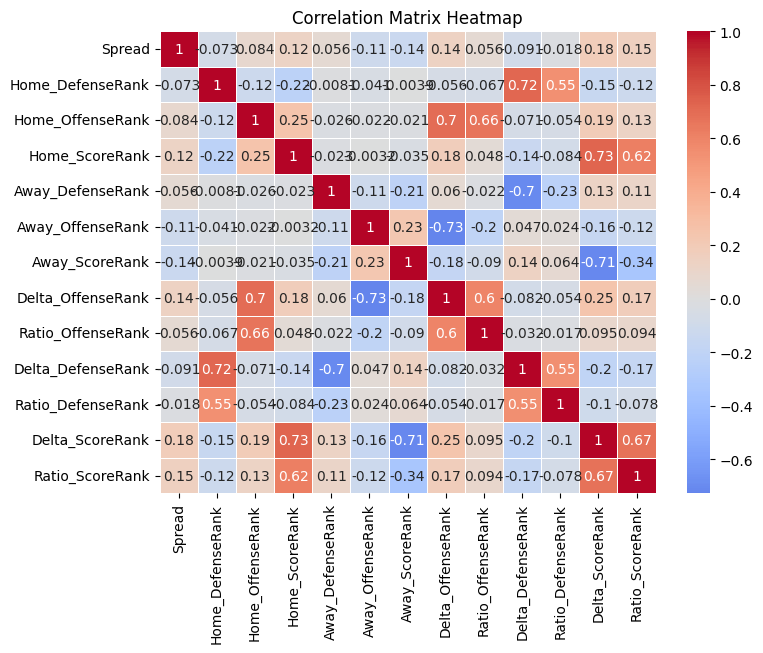

In [103]:
df = merged_played[['Spread',
                    'Home_DefenseRank', 'Home_OffenseRank', 'Home_ScoreRank', 'Away_DefenseRank',
                    'Away_OffenseRank', 'Away_ScoreRank', 'Delta_OffenseRank',
                    'Ratio_OffenseRank', 'Delta_DefenseRank', 'Ratio_DefenseRank',
                    'Delta_ScoreRank', 'Ratio_ScoreRank']]


# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

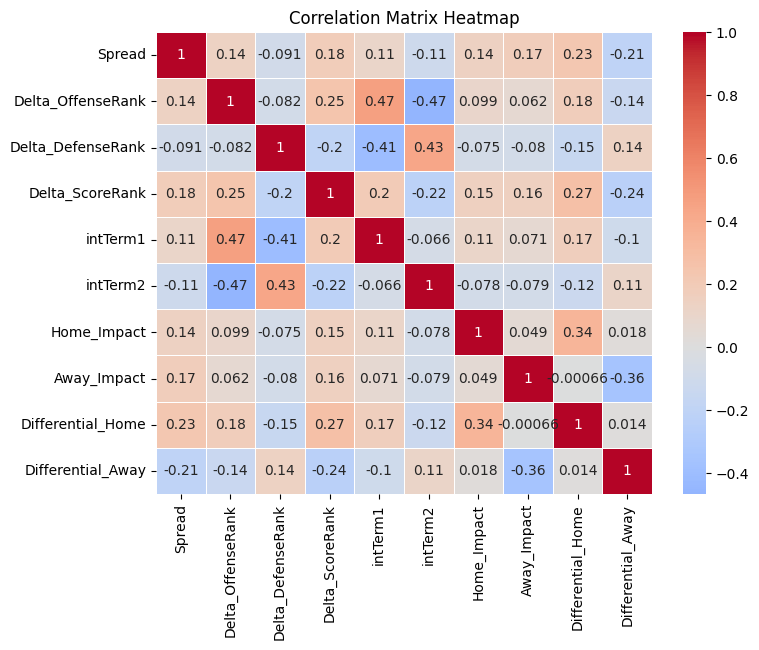

In [104]:
df = merged_played[['Spread',
                    'Delta_OffenseRank','Delta_DefenseRank', 'Delta_ScoreRank', 
                    'intTerm1', 'intTerm2',
                    'Home_Impact', 'Away_Impact',
                    'Differential_Home', 'Differential_Away',
                    ]]


# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()